In [27]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def read_labels_from_file(data_root, label_path):
    data = pd.read_csv(label_path)
    data['fn'] = data.id.map(lambda x: os.path.join(
        data_root, 'train', x + '.jpg'))
    int_to_breed = data.breed.unique()
    breed_to_int = dict((v, k) for k, v in enumerate(int_to_breed))
    data['int_breed'] = data.breed.map(lambda x: breed_to_int[x])
    
    return data.fn, data.int_breed, int_to_breed, breed_to_int

In [12]:
data_root = './data/all'
label_path = './data/all/labels.csv'

filenames, labels, int_to_breed, breed_to_int = read_labels_from_file(data_root, label_path)

list(zip(*(filenames, labels)))[:5]

[('./data/all/train/000bec180eb18c7604dcecc8fe0dba07.jpg', 0),
 ('./data/all/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', 1),
 ('./data/all/train/001cdf01b096e06d78e9e5112d419397.jpg', 2),
 ('./data/all/train/00214f311d5d2247d5dfe4fe24b2303d.jpg', 3),
 ('./data/all/train/0021f9ceb3235effd7fcde7f7538ed62.jpg', 4)]

In [86]:
means = [123.68, 116.779, 103.939]

def _parse_data(filename, label, new_size=224):
    img_string = tf.read_file(filename)
    img = tf.image.decode_jpeg(img_string)
    img = tf.image.resize_images(img, (new_size, new_size))
    img.set_shape([new_size, new_size, 3])
    img = tf.to_float(img)
    channels = tf.split(axis=2, num_or_size_splits=3, value=img)

    for i in range(3):
        channels[i] -= means[i]
    new_img = tf.concat(axis=2, values=channels)

    label = tf.cast(label, tf.int64)
    return new_img, label

In [90]:
def one_shot_input_fn(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_data).batch(1)
    
    iterator = dataset.make_one_shot_iterator()
    img, label = iterator.get_next()
    return img, label

In [91]:
def visualize_dataset(imgs, labels):
    fig, axes = plt.subplots(ncols=4, nrows=4)
    fig.set_size_inches(10, 10)

    for i, img in enumerate(imgs):
        img += means
        np.clip(img, 0, 255, img)
        img = img[0].astype(np.uint8)

        img = Image.fromarray(img)
        axes[int(i / 4), i % 4].imshow(img)
        axes[int(i / 4), i % 4].axis('off')
        axes[int(i / 4), i % 4].text(0, -10,
                                     int_to_breed[labels[i]],
                                     color='red',
                                     fontsize=11)

    plt.show()

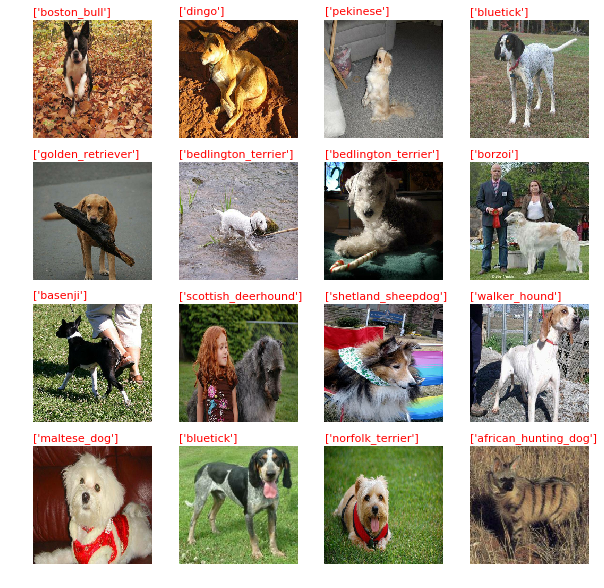

In [92]:
img, label = one_shot_input_fn(filenames, labels)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res_imgs = []
    res_labels = []
    for _ in range(16):
        res_img, res_label = sess.run([img, label])
        res_imgs.append(res_img)
        res_labels.append(res_label)

visualize_dataset(res_imgs, res_labels)

In [95]:
def initializable_input_fn(filenames, labels, train_val_ratio=0.8):
    num_files = len(filenames)
    num_train_files = int(num_files * train_val_ratio)
    train_filenames = filenames[:num_train_files]
    train_labels = labels[:num_train_files]
    val_filenames = filenames[num_train_files:]
    val_labels = labels[num_train_files:]

    train_data = tf.data.Dataset.from_tensor_slices(
        (train_filenames, train_labels))
    train_data = train_data.map(_parse_data).shuffle(1000).repeat().batch(4)

    val_data = tf.data.Dataset.from_tensor_slices(
        (val_filenames, val_labels))
    val_data = val_data.map(_parse_data).batch(1)
    
    iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                               train_data.output_shapes)
    next_element = iterator.get_next()
    
    train_init_op = iterator.make_initializer(train_data)
    val_init_op = iterator.make_initializer(val_data)
    
    return next_element, train_init_op, val_init_op

In [96]:
next_element, train_init_op, val_init_op = initializable_input_fn(filenames, labels)

In [100]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('Training...')
    for _ in range(5):
        sess.run(train_init_op)
        imgs, labels = sess.run(next_element)
        print('Image shape:', imgs.shape)
        print('Label shape:', labels.shape)
    
    print('\nValidating...')
    for _ in range(5):
        sess.run(val_init_op)
        imgs, labels = sess.run(next_element)
        print('Image shape:', imgs.shape)
        print('Label shape:', labels.shape)

Training...
Image shape: (4, 224, 224, 3)
Label shape: (4,)
Image shape: (4, 224, 224, 3)
Label shape: (4,)
Image shape: (4, 224, 224, 3)
Label shape: (4,)
Image shape: (4, 224, 224, 3)
Label shape: (4,)
Image shape: (4, 224, 224, 3)
Label shape: (4,)

Validating...
Image shape: (1, 224, 224, 3)
Label shape: (1,)
Image shape: (1, 224, 224, 3)
Label shape: (1,)
Image shape: (1, 224, 224, 3)
Label shape: (1,)
Image shape: (1, 224, 224, 3)
Label shape: (1,)
Image shape: (1, 224, 224, 3)
Label shape: (1,)
